# Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Collaborations/Avirup/Srel/'

import numpy as np
np.random.seed(5)
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import linalg
from numpy.linalg import  matrix_rank as rank
import pickle, random

# Functions for Sampling, Weight Dynamics and Loss 

In [2]:
def sample():
        features = np.empty((p,0), dtype=float)
        H = np.zeros((p,p))
        sum0 = np.zeros((p,1))
        sum1 = np.zeros((p,1))
        c = -1
        for j in range(K):
            c+= 1 
            for i in range(nk):
                if c == 1:
                  data = far_mu + far_sigma*np.random.randn(dim,1) #data is a dim sized column vector 
                  y_fake = np.matmul(W,data) #p x 1 
                  indi = (y_fake > 0).astype(float) #p x 1 
                  output = indi*y_fake #p x 1 
                  sum1 += output 
                  H += np.matmul(output,output.transpose())
                  features = np.append(features,output,axis = 1)
                else:
                  data = near_mu + near_sigma*np.random.randn(dim,1) #data is a dim sized column vector
                  y_fake = np.matmul(W,data) #p x 1 
                  indi = (y_fake > 0).astype(float) #p x 1 
                  output = indi*y_fake
                  sum0 += output 
                  H += np.matmul(output,output.transpose())
                  features = np.append(features,output,axis = 1)

        return(H,sum0/(N),sum1/(N),features)     

def w_t(w_0, t, avg):
    y = np.matmul(linalg.inv(M),avg)
    return(np.matmul(linalg.expm(-(theta**2)*t*M), w_0 - y) + y)


def loss(w0, w1, nk, K, lambda1, features ):
    # wi are p x 1 
    N = nk*K 
    e1 = np.array([1,0]) #class 1 = k : w1 is class 1 
    e2 = np.array([0,1]) #class 2 : w0 is class 2 
    S = 0 
    for i in range(nk):
        pred = np.array([np.matmul(features[:,i].reshape(1,p),w1), np.matmul(features[:,i].reshape(1,p),w0)])
        S += np.linalg.norm(e1-pred)**2

    for i in range(nk):
        pred = np.array([np.matmul(features[:,i+nk].reshape(1,p),w1), np.matmul(features[:,i+nk].reshape(1,p),w0)])
        S += np.linalg.norm(e2-pred)**2


    return S/(2*N) +  (lambda1/(2*K))*(np.linalg.norm(w0)**2 + np.linalg.norm(w1)**2)   

# Function to calculate S_Rel and return Loss and S_Rel
def SRel(samples, hki, hki_sq, hkihcj, Nhki_sq, Tkihcj, features):
  SRel_path, Loss_path = [], []
  for i in range(samples):
    Loss_path_i, SRel_path_i = [],[] 
    w0_0, w1_0 = np.random.randn(p,1), np.random.randn(p,1)
    for t in range(T):
        w0_now, w1_now = w_t(w0_0,t,avg0), w_t(w1_0,t,avg1)
        w0_t_T, w1_t_T = w0_now.transpose(), w1_now.transpose() #w_k(t) # 1 x p  # 1 x p 

        if t%100 == 0:
           Loss_path_i.append(loss(w0_now, w1_now, nk, K, lambda1, features))
        
        a = np.matmul(w1_t_T,Tkihcj)**2 + np.matmul(w0_t_T,Tkihcj)**2 
        b = np.matmul(w1_t_T,hki)**2 + np.matmul(w0_t_T,hki)**2
         
        # Equation (8) in paper to calculate SRel
        Num = hkihcj**2 - 2*hkihcj*np.matmul(w1_t_T,Tkihcj) + a
        Den = hki_sq**2 - 2*hki_sq*Nhki_sq*np.matmul(w1_t_T,hki) + (Nhki_sq**2)*b

        SRel_path_i.append(np.sqrt((Num/Den).flatten())) 
  
    SRel_path_i = np.array(SRel_path_i)
    Loss_path_i = np.array(Loss_path_i)
    SRel_path.append(SRel_path_i)
    Loss_path.append(Loss_path_i)

  return SRel_path,Loss_path

# Sampling Data + Gradient Flow + Computing SRel + Plots

In [5]:
far_mu = 9 #mean of each axis of one of the two Gaussian components of the data 
near_mu = 1 #mean of each axis of of one of two Gaussian components of the data 
far_sigma =  1 #SD of each axis of the Gaussian data component with mean far_mu 
near_sigma = 2 #SD of each axis of the Gaussian data component with mean near_mu

p = 10
dim = 100
nk = 1000 
K = 2 
N = nk*K 
lambda1 = 1
theta = 0.001 

W = np.random.randn(p,dim)


(H,avg0,avg1,features) = sample() 

M = (( N * lambda1)/K)*np.identity(p) + (1/N)*H 

# Taking a random sample of 20 tuples, 10 from each class
smooth_n = 20     # Number of samples to be taken from each class for smoothened S_Rel
hcj= [features[:,i].reshape(p,1) for i in random.sample(range(0,nk-1),smooth_n)] #class 0 - so c = 0 
hki = [features[:,i].reshape(p,1) for i in random.sample(range(nk,N-1),smooth_n)] #class 1 - so k = 1 

# Store SRel and Loss in lists
SRel_path, Loss_path = [], []
for idx in range(smooth_n):
    Tki = (( N * lambda1)/K)*np.identity(p) + (1/N)*np.matmul(hki[idx],hki[idx].transpose())
    Tkihcj = np.matmul(Tki,hcj[idx]) # p x 1 
    hkihcj = np.matmul(hcj[idx].transpose(),hki[idx])
    hki_sq = np.matmul(hki[idx].transpose(),hki[idx])
    Nhki_sq = (( N * lambda1)/K) + hki_sq 

    T = 1+8*10**3
    LT = 1+int((T-1)/100)
    samples = 10 
    SRel_path_i, Loss_path_i = SRel(samples, hki[idx], hki_sq, hkihcj, Nhki_sq, Tkihcj, features)
    SRel_path.append(SRel_path_i)
    Loss_path.append(Loss_path_i)

# Saving metrics and S_rel
with open(path+f'Loss_path_avg_p{p}_dim{dim}.pkl', 'wb') as f:
    pickle.dump(Loss_path, f)

with open(path+f'SRel_path_avg_p{p}_dim{dim}.pkl', 'wb') as f:
    pickle.dump(SRel_path, f)

#Smoothening SRel
SRel_path= np.sum(np.array(SRel_path),0)/smooth_n**2
Loss_path= np.sum(np.array(Loss_path),0)/smooth_n

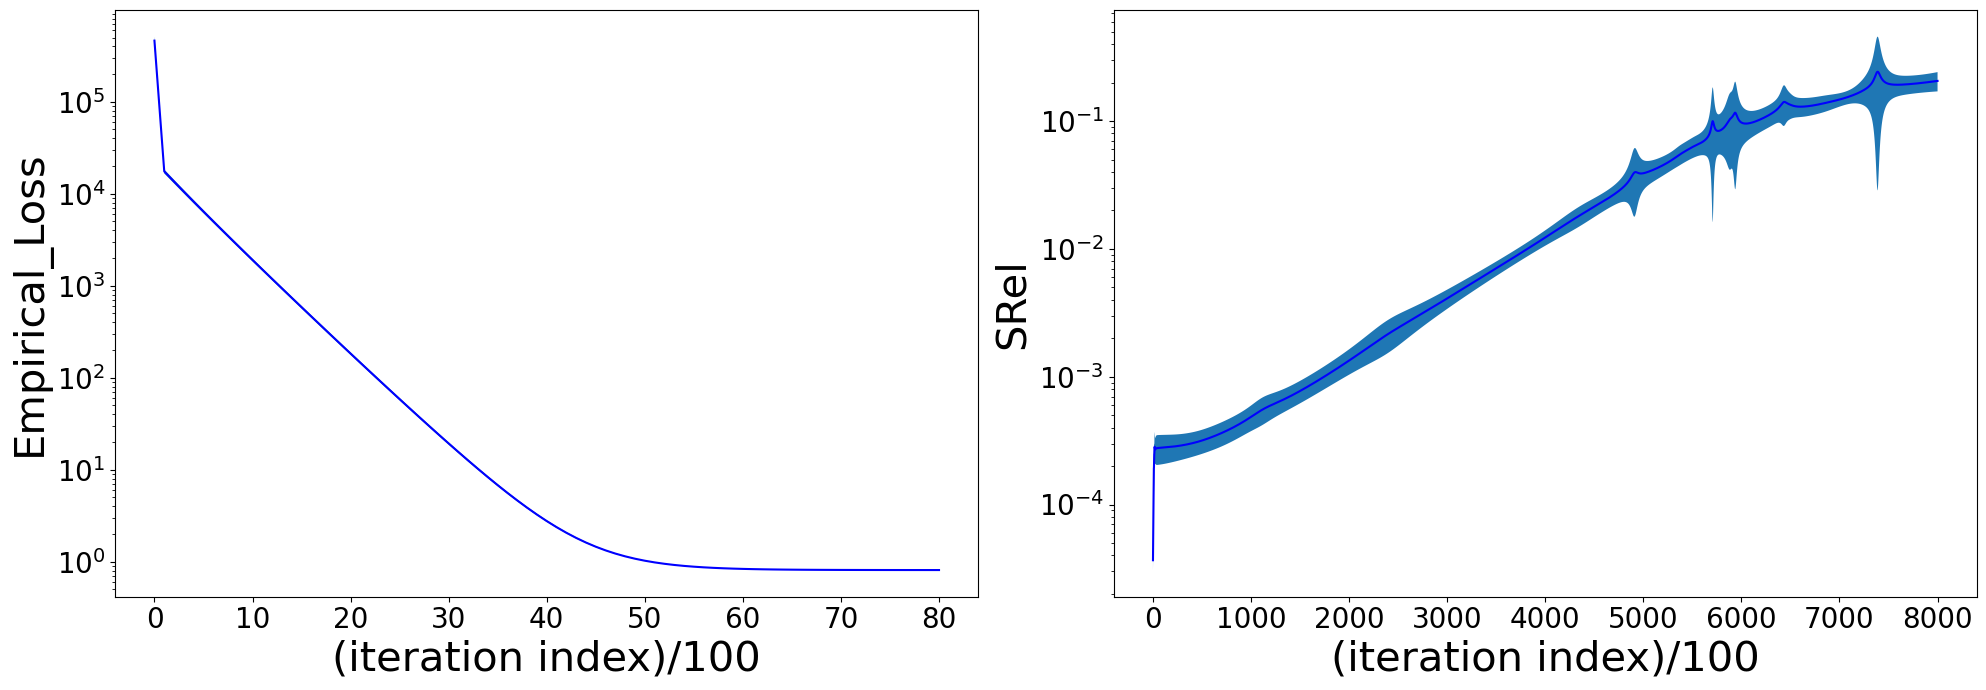

In [6]:
# Plotting figures
loss_mean, loss_sd = np.mean(np.array(Loss_path),0), np.std(np.array(Loss_path),0)
srel_mean, srel_sd = np.mean(np.array(SRel_path),0).flatten(), np.std(np.array(SRel_path),0).flatten()
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs[0].plot(range(LT), loss_mean, color='blue')
axs[0].fill_between(range(LT),loss_mean-loss_sd,loss_mean+loss_sd)
axs[0].set_xlabel('(iteration index)/100', fontsize=30)
axs[0].set_yscale('log')
axs[0].set_ylabel('Empirical_Loss', fontsize=30)
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)

axs[1].plot(range(T), np.mean(np.array(SRel_path),0), color='blue')
axs[1].fill_between(range(T),srel_mean-srel_sd,srel_mean+srel_sd)
axs[1].set_xlabel('(iteration index)/100', fontsize=30)
axs[1].set_yscale('log')
axs[1].set_ylabel("SRel", fontsize=30)
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)

fig.tight_layout()
fig.savefig(path+f'N_p_{p}_dim_{dim}_nk_1000_lamb_1_theta_0_001.png',bbox_inches='tight')